## Linear Regression
Training a model to predict the fare of a taxi in Chicago


In [40]:
# Install required libraries

## data
import pandas as pd
import numpy as np

## visualization
import matplotlib.pyplot as plt
import plotly.express as px

import keras
from keras import layers


# Load Dataset
we will load the dataset and create a pandas dataFrame.
A dataFrame is wil a spreadsheet with rows and cols, with rows representing individual data examples and cols representing the attributes associated with each example.

In [41]:
chicago_taxi_dataset = pd.read_csv("chicago_taxi_train.csv")

# lets clean the dataset by only using specific columns that are relevent in trying to predict the price
# training_df = chicago_taxi_dataset.loc

print(chicago_taxi_dataset.shape) #this will tell us the number of rows (31694) and cols (18)
chicago_taxi_dataset.head()       #show the fisrt 5 rows

(31694, 18)


,TRIP_START_TIMESTAMP,TRIP_END_TIMESTAMP,TRIP_START_HOUR,TRIP_SECONDS,TRIP_MILES,TRIP_SPEED,PICKUP_CENSUS_TRACT,DROPOFF_CENSUS_TRACT,PICKUP_COMMUNITY_AREA,DROPOFF_COMMUNITY_AREA,FARE,TIPS,TIP_RATE,TOLLS,EXTRAS,TRIP_TOTAL,PAYMENT_TYPE,COMPANY
0,05/17/2022 7:15:00 AM,05/17/2022 7:45:00 AM,7.25,2341,2.57,4.0,NaN,NaN,NaN,17.0,31.99,2.0,6.3,0.0,0.0,33.99,Mobile,Flash Cab
1,05/17/2022 5:15:00 PM,05/17/2022 5:30:00 PM,17.25,1074,1.18,4.0,NaN,1.703108e+10,NaN,8.0,9.75,3.0,27.9,0.0,1.0,14.25,Credit Card,Flash Cab
2,05/17/2022 5:15:00 PM,05/17/2022 5:30:00 PM,17.25,1173,1.29,4.0,1.703132e+10,1.703108e+10,32.0,8.0,10.25,0.0,0.0,0.0,0.0,10.25,Cash,Sun Taxi
3,05/17/2022 6:00:00 PM,05/17/2022 7:00:00 PM,18.00,3360,3.70,4.0,1.703132e+10,1.703124e+10,32.0,24.0,23.75,0.0,0.0,0.0,1.0,24.75,Cash,Choice Taxi Association
4,05/17/2022 5:00:00 PM,05/17/2022 5:30:00 PM,17.00,1044,1.15,4.0,1.703132e+10,1.703108e+10,32.0,8.0,10.00,0.0,0.0,0.0,0.0,10.00,Cash,Flash Cab


The data seems to have missing values, we will try to identify all these values by using pythons build in function .isnull() or .notnull() (which is a boolean value).

In [42]:
chicago_taxi_dataset.isnull().any().any()

np.True_

In [43]:
chicago_taxi_dataset.isnull().sum()

,0
TRIP_START_TIMESTAMP,0
TRIP_END_TIMESTAMP,0
TRIP_START_HOUR,0
TRIP_SECONDS,0
TRIP_MILES,0
TRIP_SPEED,0
PICKUP_CENSUS_TRACT,18435
DROPOFF_CENSUS_TRACT,17671
PICKUP_COMMUNITY_AREA,3217
DROPOFF_COMMUNITY_AREA,3495


True: tells us that there are empty/missing values. The we used sum() to find out how many and in each cols.

Before we try to figure out how we are going to deal with the missing values, either by replacing with the mean, frequency or removing that whole row, lets find out if we actually need these columns at all. We do this by evaluating if these cols have any impact to what we are tryoing to predict.

In [44]:
# let remove some of the cols
# the following line updates the dataframe to use specific cols
training_df = chicago_taxi_dataset.loc[:, ('TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'TIP_RATE', 'PAYMENT_TYPE', 'COMPANY')]

print('\n\nTotal number of rows {0}\n'.format(len(training_df.index)))
print('Total number of rows and cols', training_df.shape, ('\n'))
training_df.head(200) #shows the first 200



Total number of rows 31694

Total number of rows and cols (31694, 6) 



,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE,PAYMENT_TYPE,COMPANY
0,2.57,2341,31.99,6.3,Mobile,Flash Cab
1,1.18,1074,9.75,27.9,Credit Card,Flash Cab
2,1.29,1173,10.25,0.0,Cash,Sun Taxi
3,3.70,3360,23.75,0.0,Cash,Choice Taxi Association
4,1.15,1044,10.00,0.0,Cash,Flash Cab
...,...,...,...,...,...,...
195,1.13,821,9.00,22.9,Mobile,Blue Ribbon Taxi Association
196,0.57,414,6.00,0.0,Cash,Flash Cab
197,1.22,886,9.00,0.0,Cash,City Service
198,1.68,1219,9.00,23.0,Mobile,Sun Taxi


# 2. Data Exploration

## View dataset statistics
A large part of ML is getting to know your data. We will use the DataFrame.describe method to view descriptivw statistics about the dataset and answer some important questions about the data.

In [45]:
training_df.describe(include='all')

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE,PAYMENT_TYPE,COMPANY
count,31694.000000,31694.000000,31694.000000,31694.000000,31694,31694
unique,NaN,NaN,NaN,NaN,7,31
top,NaN,NaN,NaN,NaN,Credit Card,Flash Cab
freq,NaN,NaN,NaN,NaN,14142,7887
mean,8.289463,1319.796397,23.905210,12.965785,NaN,NaN
std,7.265672,928.932873,16.970022,15.517765,NaN,NaN
min,0.500000,60.000000,3.250000,0.000000,NaN,NaN
25%,1.720000,548.000000,9.000000,0.000000,NaN,NaN
50%,5.920000,1081.000000,18.750000,12.200000,NaN,NaN
75%,14.500000,1888.000000,38.750000,20.800000,NaN,NaN


From the above, we can see the max fare, mean distance, most frequent payment type and that if there is missing values.

This can also be done explicily, in the following manner:

In [46]:
# what is the maximun fare?
max_fare = training_df["FARE"].max()
#print('The maximun fare is: $',max_fare)
print('The maximun fare is: ${fare:.2f}'.format(fare = max_fare))

#what is the mean distance across all trips?
mean_dis = training_df['TRIP_MILES'].mean()
print('The mean distance is: {:.4f} miles'.format(mean_dis))

#How many cab companies are in the dataset?
num_unique_companies = training_df['COMPANY'].nunique()
print('The number of campanies in the dataset are:', num_unique_companies)

# What is the most frequent payment type?
most_pay_type = training_df['PAYMENT_TYPE'].value_counts().idxmax()
print('The most frequent payment type is:', most_pay_type)

# Lastly we will find out if we have missing data in our df
missing_values = training_df.isnull().sum().sum()
print('The number of missing values is:', missing_values)

The maximun fare is: $159.25
The mean distance is: 8.2895 miles
The number of campanies in the dataset are: 31
The most frequent payment type is: Credit Card
The number of missing values is: 0


## Generate a correlation matrix

An important part of ML is dedtermining which `features` correlate with the `label`. Having taking an uber before, the fare is most linked to the distance and time of the trip, is there a way to learn more about how well these features correlate to the fare(label)?

We will use correlation matrix to identify whose values correlate well with the label. Correlation values have the following meanings:

* **`1.0`**: perfect positive correlation; that is, when one attribute rises, the other attribute rises as well.
* **`-1.0`**: perect negative correlation; that is, when one attribute rises, the other attribute falls.
* **`0.0`**: no correlation; the two columns are not kinearly related.

In general, the higher the absolute value of a correlation value, the greater its predictive power.







In [47]:
# view correlation matrix
training_df.corr(numeric_only = True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.000000,0.800855,0.975344,-0.049594
TRIP_SECONDS,0.800855,1.000000,0.830292,-0.084294
FARE,0.975344,0.830292,1.000000,-0.070979
TIP_RATE,-0.049594,-0.084294,-0.070979,1.000000


From the above we can see that `TRIP_MILES` has the highest correlation with `FARE`. And the `TRIP_SECONDS` has the second highest correlation with `FARE` in our dataset. It is expected that Trip miles must to very correlated with price, and looks like a good feature to start with to train the model.

The feature with the lowest correlation with the dataset is `TIP_RATE`. ;) seems we do not like tipping the higher the price (FARE) gets.


## Visualise realtionships in dataset

Sometimes it is imported to visualise these relationships between the features in a dataset; one way to do this is with a pair plot. A **pair plot** generates a grid of pairwise plots to visualise the relationship of each feature with all other features all inone place.


In [48]:
px.scatter_matrix(training_df, dimensions=['FARE', 'TRIP_MILES', 'TRIP_SECONDS'])

# Part 3. Train Model

---

## Define functions to build and train a model


In [49]:
# Define ML functions
class ExperimentSettings:
  def __init__(
      self,
      input_features,
      target_feature,
      learning_rate=0.01,
      batch_size=32,
      number_epochs=20,
  ):
      self.input_features = input_features
      self.target_feature = target_feature
      self.learning_rate = learning_rate
      self.batch_size = batch_size
      self.number_epochs = number_epochs

  def to_dict(self):
    return {
        "input_features": self.input_features,
        "target_feature": self.target_feature,
        "learning_rate": self.learning_rate,
        "batch_size": self.batch_size,
        "number_epochs": self.number_epochs,
    }

class Experiment:
  def __init__(self, name, settings, model, epochs, metrics_history):
    self.name = name
    self.settings = settings
    self.model = model
    self.epochs = epochs
    self.metrics_history = metrics_history

  def summary(self):
    return {
        "name": self.name,
        "epochs_ran": len(self.epochs),
        "final_metrics": {
            metric: values[-1]
            for metric, values in self.metrics_history.items()
        },
    }

def create_model(settings, metrics) -> keras.Model:

  # Create named inputs
  inputs = {
      name: keras.Input(shape=(1, ), name=name)
      for name in settings.input_features
  }

  # Concatenate inputs
  Concatenated_inputs = layers.Concatenate()(list(inputs.values()))

  #linear regression output
  outputs = layers.Dense(units=1)(Concatenated_inputs)

  #Build model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile model
  model.compile(
      optimizer=keras.optimizers.RMSprop(learning_rate=settings.learning_rate),
      loss="mean_squared_error",
      metrics=metrics,
  )

  return model





In [50]:
def train_model(experiment_name: str, model: keras.Model, dataset: pd.DataFrame, label_name: str, settings,):
  """Train the model by feeding it data"""

  #Prepare features
  features = { name: dataset[name].values for name in settings.input_features}
  label = dataset[label_name].values
  # Train
  history = model.fit(x=features, y=label, batch_size= settings.batch_size, epochs= settings.number_epochs)

  #Build Experiment object
  experiment = Experiment(name=experiment_name, settings=settings, model=model, epochs=history.epoch, metrics_history=pd.DataFrame(history.history))
  return experiment

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


## Training a model with one feature

Will we train a model to predict the cost of Fare using a single feature. We have seen that distance strongly correlates with `FARE`, so we will start with `TRIP_MIILES` as the feature for your first training run.

Pay attention to:
* How many epochs did it take to converge on the final model?
* How well does the model fit the sample data?

During training, we should see the root mean square error (RMSE) in the output, which has the same units as the label. In other words, you can use the RMSE to determine how far off, on average, the predicted fares are in dollars from the observed values.

In [51]:
# the following variables are the hyperparameters
#TODO - ADjust these hhyperparameters to see how they impact a training run

settings_1 = ExperimentSettings(
    learning_rate = .001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES'],
    target_feature = ['FARE']
)

# Define metrics
metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

# Create and Train model
model_1 = create_model(settings_1, metrics)

experiment_1 = train_model(
    experiment_name = 'one_feature',
    model = model_1,
    dataset = training_df,
    label_name = 'FARE',
    settings = settings_1
)






Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 280.0652 - rmse: 16.7040
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 97.2914 - rmse: 9.8313
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.4714 - rmse: 4.9365
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 17.7471 - rmse: 4.2079
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.7097 - rmse: 4.1820
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.3872 - rmse: 3.9180
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.7144 - rmse: 3.6982
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.0165 - rmse: 3.7386
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.7675 - rmse: 3.8385
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.8466 - rmse: 3.5805
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.6982 - rmse: 3.8255
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.5489 - rmse: 3.6758

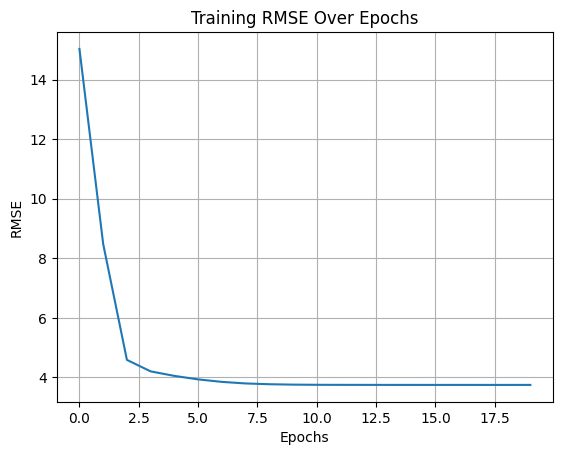

In [52]:
def plot_experiment_metrics(experiment, metric_names):
  history = experiment.metrics_history

  for metric in metric_names:
    if metric not in history:
      raise ValueError(f"Metric '{metric}' not found in experiment history.")
    plt.figure()
    plt.plot(history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric.upper())
    plt.title(f"Training {metric.upper()} Over Epochs")
    plt.grid(True)
    plt.show()

plot_experiment_metrics(experiment_1, ['rmse'])



991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


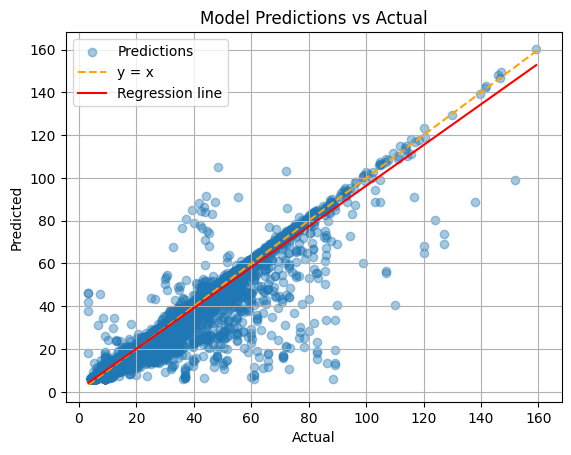

In [53]:
def plot_model_predictions(experiment, dataset, label_name):
  model = experiment.model

  #Prepare feature dict
  features = {name: dataset[name].values for name in experiment.settings.input_features}
  predictions = model.predict(features).flatten()
  actual = dataset[label_name].values


  plt.figure()
  plt.scatter(actual, predictions, alpha=0.4, label="Predictions")

  # Add identity line y = x
  min_val = min(np.min(actual), np.min(predictions))
  max_val = max(np.max(actual), np.max(predictions))
  plt.plot([min_val, max_val], [min_val, max_val], color='orange', linestyle='--', label="y = x")

  # Fitted regression line (trend)
  coef = np.polyfit(actual, predictions, 1)
  poly_fn = np.poly1d(coef)
  sorted_actual = np.sort(actual)
  plt.plot(sorted_actual, poly_fn(sorted_actual), color='red', label="Regression line")

  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title("Model Predictions vs Actual")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_model_predictions(experiment_1, training_df, 'FARE')

## Experiment with hyperparameters
It is common with machine learning to run multiple experiments to find the best set of hyperparameters to train your model. In this step, try varying the hyperparameters one by one with this set of experiments:
* Experiment 1: **Increase** the learning rate to `1.0` (batch size at `50`).
* Experiment 2: **Decrease** the learning rate `0.0001` (batch size at `50`).
* Experiment 3: **Increase** the batch size to `500` (learning rate at `0.001`).

Check the following:
* How did raising the learning rate impact your ability to train the model?
* How did lowering the learning rate impact your ability to train the model?
* Did changing the batch size effect your training results?

In [54]:
# the following variable are the hyperparameters
#TODO - Adjust these hyperparameters to see how they impact a training run
settings_2 = ExperimentSettings(
    learning_rate = .001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES'],
    target_feature = 'FARE'
)

#Define metrics
metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

#create and train model
model_2 = create_model(settings_2, metrics)

experiment_2 = train_model(
    experiment_name='one_feature_hyper',
    model=model_2,
    dataset=training_df,
    label_name='FARE',
    settings=settings_2
)

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 244.2090 - rmse: 15.5910
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 79.0117 - rmse: 8.8595
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.7679 - rmse: 4.5554
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.2119 - rmse: 4.2603
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.1972 - rmse: 4.0190
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.5706 - rmse: 3.9362
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.0161 - rmse: 3.7392
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.7591 - rmse: 3.8388
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.9557 - rmse: 3.7322
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.9684 - rmse: 3.7339
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.1919 - rmse: 3.8926
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.9126 - rmse: 3.7188

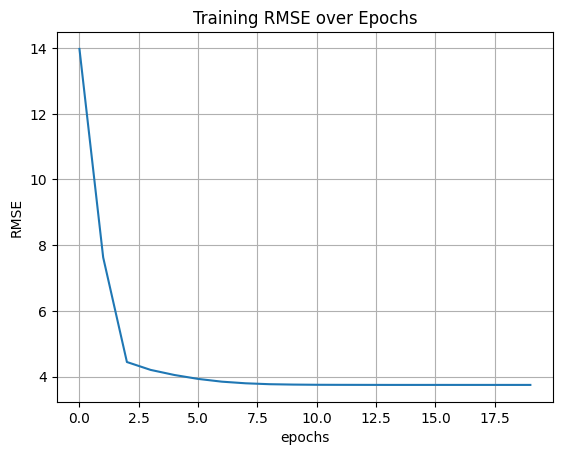

In [55]:
#Plotting the experimental metrics
def plot_experiment_metrics(experiment, metric_names):
  history = experiment.metrics_history

  for metric in metric_names:
    if metric not in history:
      raise ValueError(f"Metric '{metric}' not found in experiment history")
    plt.figure()
    plt.plot(history[metric])
    plt.xlabel("epochs")
    plt.ylabel(metric.upper())
    plt.title(f"Training {metric.upper()} over Epochs")
    plt.grid()
    plt.show()

plot_experiment_metrics(experiment_2, ['rmse'])

991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


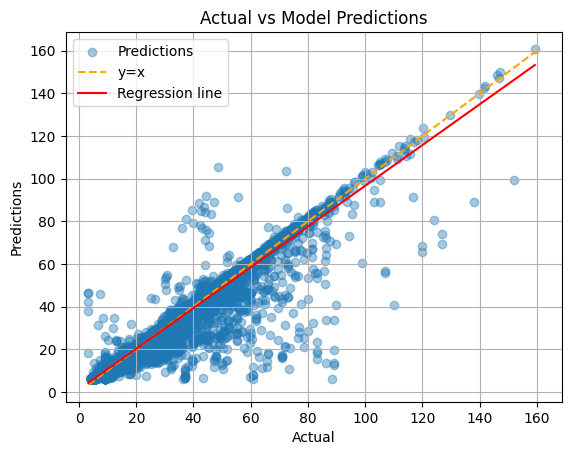

In [56]:
#plotting the prediction model
def plot_model_predictions(experiment, dataset, label_name):
  model = experiment.model

  #prepare feature dict
  features = {name: dataset[name].values for name in experiment.settings.input_features}
  predictions = model.predict(features).flatten().flatten()
  actual = dataset[label_name].values

  plt.figure()
  plt.scatter(actual, predictions, alpha=.4, label="Predictions")

  # Add identify line y=x
  min_val = min(np.min(actual), np.min(predictions))
  max_val = max(np.max(actual), np.max(predictions))
  plt.plot([min_val, max_val], [min_val, max_val], color = 'orange', linestyle = '--', label = 'y=x')

  #Fit regression line (trend)
  coef = np.polyfit(actual, predictions, 1)
  poly_fn = np.poly1d(coef)
  sorted_actual = np.sort(actual)
  plt.plot(sorted_actual, poly_fn(sorted_actual), color='red', label='Regression line')

  plt.xlabel('Actual')
  plt.ylabel("Predictions")
  plt.title("Actual vs Model Predictions")
  plt.grid()
  plt.legend()
  plt.show()

plot_model_predictions(experiment_2, training_df, 'FARE')

# Training a model with two features

Our first model we trained with the feature `TRIP_MILES` demonstrates fairly strong predictive power, but is it possible to do better?

We will try to train a model using two features, `TRIP_MILES`and `TRIP_SECONDS` to see if we can better our model predictions.
We should then be able to tell the following:
* Does the model with two features produce better results than the one using a single feature?
* Does it make difference if we use Trip_Seconds or converting it to minutes?
* How well would you say the model comes to the ground true of predicting the FARE price?

Notice that the scatter plot of the features vs. the label is a three dimensional (3-D) plot. This representation allows you to visualize both features and the label all together. The two features (TRIP_MILES and TRIP_MINUTES) are on the x and y axis, and the label (FARE) is on the z axis. The plot shows individual examples in the dataset as circles, and the model as a surface (plane). With this 3-D model, if the trained model is good you would expect most of the examples to land on the plane surface. The 3-D plot is interactive so you can explore the data further by clicking or dragging the plot.

In [57]:
# The following are the hyperparameters of Ex 3 for two features
settings_3 = ExperimentSettings(
    learning_rate = .001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MINUTES', 'TRIP_MILES'],
    target_feature = 'FARE'
)

#converting seconds to minutes
training_df['TRIP_MINUTES'] = training_df['TRIP_SECONDS']/60

#Define metrics
metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_3 = create_model(settings_3, metrics)

experiment_3 = train_model(
    experiment_name = 'two_features',
    model = model_3,
    dataset = training_df,
    label_name = 'FARE',
    settings = settings_3
)


Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1815.1748 - rmse: 42.4886
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 393.0208 - rmse: 19.6133
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.6000 - rmse: 4.3054
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.9707 - rmse: 3.5975
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.4707 - rmse: 3.5292
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.4895 - rmse: 3.6492
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.0258 - rmse: 3.4541
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.3527 - rmse: 3.7617
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.1720 - rmse: 3.3326
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.1677 - rmse: 3.4832
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.8544 - rmse: 3.4376
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.4000 - rmse: 3.5

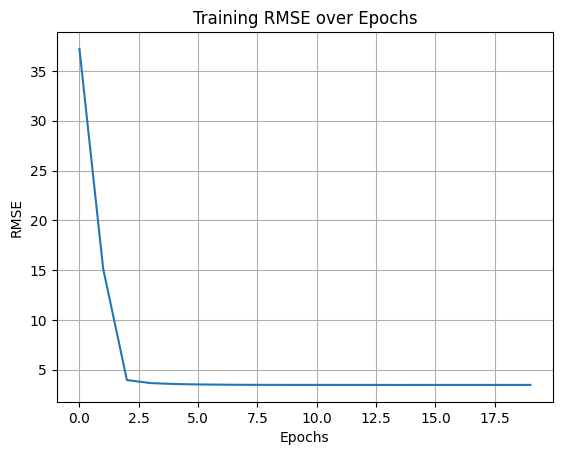

In [58]:
# ploting the experimental metrics
def plot_experiment_metrics(experiment, metric_name):
  history = experiment.metrics_history

  for metric in metric_name:
    if metric not in history:
      raise ValueError(f"Metric '{metric}' not found in experiment history")
    plt.figure()
    plt.plot(history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric.upper())
    plt.title(f"Training {metric.upper()} over Epochs")
    plt.grid()
    plt.show()

plot_experiment_metrics(experiment_3, ['rmse'])

991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


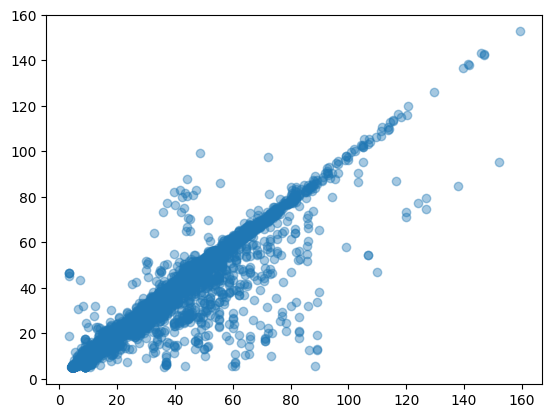

In [59]:
def plot_model_predictions(experiment, dataset, label_name):
  model = experiment.model

  #Prepare feature dic
  features = {name: dataset[name].values for name in experiment.settings.input_features}
  predictions = model.predict(features).flatten()
  actual = dataset[label_name].values

  plt.figure()
  plt.scatter(actual, predictions, alpha=.4, label='Predictions')

plot_model_predictions(experiment_3, training_df, 'FARE')

## Compare Experiments


          ===--------- Experiment Summary -----------=== 



,experiment,learning_rate,batch_size,epochs,final_rmse
0,one_feature,0.001,50,20,3.745859
1,two_features,0.001,50,20,3.478146




      ----------------------------------------------------------- 




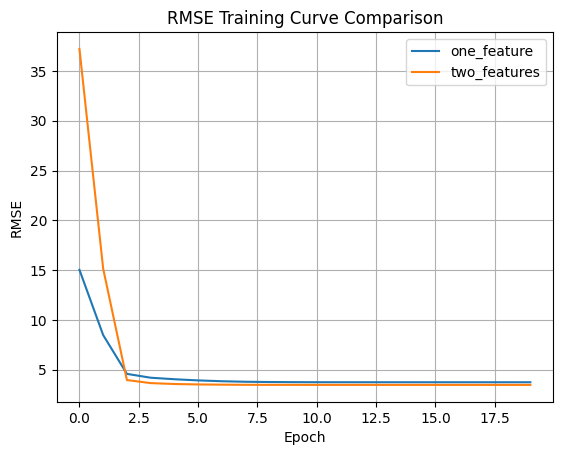

991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 ------------------------------------------------------------- 




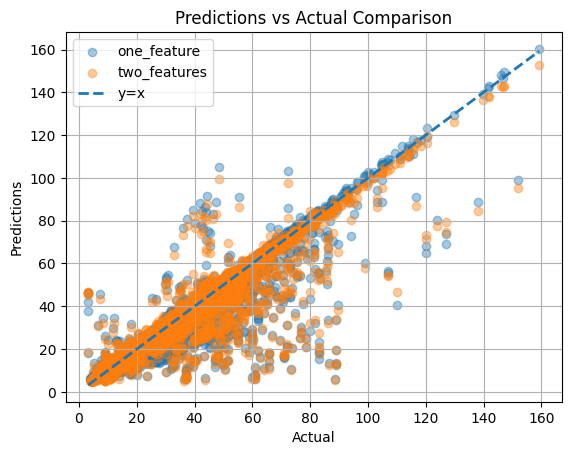

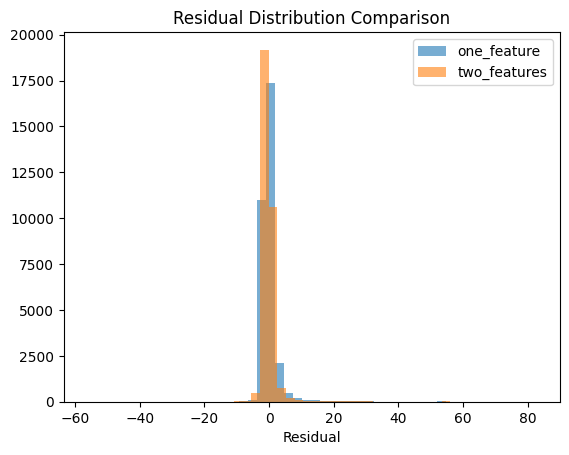



======================= Conclusion ========================== 

Winner based on final RMSE: two_features
one_feature: 3.7459
two_features: 3.4781



In [66]:
def compare_experiments(exp_a, exp_b, dataset, label_name, metric):
  """
      Compare two experiments across metrics, predictions, and residuals
  """
  # ---------------------- Summary Table ----------------------------------
  summary = pd.DataFrame([
      {
          "experiment": exp_a.name,
          "learning_rate": exp_a.settings.learning_rate,
          "batch_size": exp_a.settings.batch_size,
          "epochs": len(exp_a.epochs),
          f"final_{metric}": exp_a.metrics_history[metric].iloc[-1]
      },
      {
          "experiment": exp_b.name,
          "learning_rate": exp_b.settings.learning_rate,
          "batch_size": exp_b.settings.batch_size,
          "epochs": len(exp_b.epochs),
          f"final_{metric}": exp_b.metrics_history[metric].iloc[-1]
      }
  ])
  print('\n          ===--------- Experiment Summary -----------=== \n')
  display(summary)

  #training Curve
  plt.figure()
  plt.plot(exp_a.metrics_history[metric], label = exp_a.name)
  plt.plot(exp_b.metrics_history[metric], label = exp_b.name)
  plt.xlabel("Epoch")
  plt.ylabel(metric.upper())
  plt.title(f'{metric.upper()} Training Curve Comparison')
  plt.legend()
  plt.grid()
  print('\n\n      ----------------------------------------------------------- \n\n')
  plt.show()

  # ---------------------- Predictions ------------------------------
  features_a = {
      name: dataset[name].values
      for name in exp_a.settings.input_features
  }
  features_b = {
      name: dataset[name].values
      for name in exp_b.settings.input_features
  }
  actual = dataset[label_name].values
  predictions_a = exp_a.model.predict(features_a).flatten()
  predictions_b = exp_b.model.predict(features_b).flatten()

  min_val = min(actual.min(), predictions_a.min(), predictions_b.min())
  max_val = max(actual.max(), predictions_b.max(), predictions_b.max())

  plt.figure()
  plt.scatter(actual, predictions_a, alpha=.4, label=exp_a.name)
  plt.scatter(actual, predictions_b, alpha=.4, label=exp_b.name)
  plt.plot([min_val, max_val], [min_val, max_val], linestyle = '--', linewidth =2, label = "y=x")
  plt.xlabel("Actual")
  plt.ylabel("Predictions")
  plt.title("Predictions vs Actual Comparison")
  plt.legend()
  plt.grid()
  print("\n\n ------------------------------------------------------------- \n\n")

  # -------------------- --- Residual --- --------------------------------------
  res_a = actual - predictions_a
  res_b = actual - predictions_b

  plt.figure()
  plt.hist(res_a, bins=50, alpha=.6, label=exp_a.name)
  plt.hist(res_b, bins=50, alpha=.6, label=exp_b.name)
  plt.xlabel("Residual")
  plt.title("Residual Distribution Comparison")
  plt.legend()
  plt.show()

  # ---------------------------- Winner --------------------------------------------
  Final_a = exp_a.metrics_history[metric].iloc[-1]
  final_b = exp_b.metrics_history[metric].iloc[-1]

  winner = exp_a.name if Final_a < final_b else exp_b.name
  print("\n\n======================= Conclusion ========================== \n")
  print(
      f"Winner based on final {metric.upper()}: {winner}\n"
      f"{exp_a.name}: {Final_a:.4f}\n"
      f'{exp_b.name}: {final_b:.4f}\n'
  )

#calling our function
compare_experiments(experiment_1, experiment_3, training_df, 'FARE', 'rmse')

# Using the model to make Predictions

In [75]:
# Define functions to make predictions
def format_currency(x):
  return "R{:.2f}".format(x)

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.reset_index(drop=True, inplace=True)
  return batch

def predict_fare(model, df, features, label, batch_size=50):
  batch = build_batch(df, batch_size)

  #Build model inputs
  inputs = {name: batch[name].values for name in features}
  predictions = model.predict(inputs).flatten()

  rows = []
  for i in range(batch_size):
    row = {
        "PREDICTED_FARE": predictions[i],
        "OBSERVED_FARE": batch.at[i, label],
        "L1_LOSS": abs(batch.at[i, label] - predictions[i])
    }

    #Add feature values dynamically
    for feature in features:
      row[feature] = batch.at[i, feature]

    rows.append(row)
  return pd.DataFrame(rows)


def show_predictions(df):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)

  display_df = df.copy()
  display_df["PREDICTED_FARE"] = display_df["PREDICTED_FARE"].apply(format_currency)
  display_df["OBSERVED_FARE"] = display_df["OBSERVED_FARE"].apply(format_currency)
  display_df["L1_LOSS"] = display_df["L1_LOSS"].apply(format_currency)
  print(display_df)

output = predict_fare(
    model = experiment_3.model,
    df=training_df,
    features = experiment_3.settings.input_features,
    label = 'FARE',
    batch_size = 50
)

show_predictions(output)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
   PREDICTED_FARE OBSERVED_FARE L1_LOSS  TRIP_MINUTES  TRIP_MILES
0           R9.36         R9.25   R0.11     15.183333        1.62
1           R7.56         R6.75   R0.81      6.000000        1.40
2          R11.17        R10.75   R0.42     11.933333        2.75
3          R48.83        R45.50   R3.33     59.216667       17.90
4           R8.00         R7.50   R0.50      7.066667        1.54
5          R29.06        R28.25   R0.81     20.000000       11.00
6          R18.20        R17.75   R0.45     15.000000        6.00
7          R10.58        R10.00   R0.58      8.383333        2.72
8          R71.30        R73.75   R2.45     40.000000       30.40
9           R8.57         R8.00   R0.57      8.583333      